In [1]:
import gensim
from gensim import utils
import numpy as np
import sys
from sklearn.datasets import fetch_20newsgroups
from nltk import word_tokenize
from nltk import download
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

In [ ]:
#model Google News, run once to download pre-trained vectors
#!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

In [2]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

### Tokenize, remove stopwords

In [3]:
download('punkt') #tokenizer, run once
download('stopwords') #stopwords dictionary, run once
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] #restricts string to alphabetic characters only
    return doc

[nltk_data] Downloading package punkt to /home/sdimi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sdimi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
############  doc content  -> num label     -> string label
#note to self: texts[XXXX] -> y[XXXX] = ZZZ -> ng20.target_names[ZZZ]

# Fetch ng20 dataset
ng20 = fetch_20newsgroups(subset='all',
                          remove=('headers', 'footers', 'quotes'))
# text and ground truth labels
texts, y = ng20.data, ng20.target

corpus = [preprocess(text) for text in texts]

### Remove empty docs

In [5]:
def filter_docs(corpus, texts, labels, condition_on_doc):
    """
    Filter corpus, texts and labels given the function condition_on_doc which takes
    a doc.
    The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    labels = [i for (i, doc) in zip(labels, corpus) if condition_on_doc(doc)]
    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts, labels)

In [6]:
corpus, texts, y = filter_docs(corpus, texts, y, lambda doc: (len(doc) != 0))

555 docs removed


### Remove OOV words and documents with no words in model dictionary

In [7]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.vocab]
    return np.mean(word2vec_model[doc], axis=0)

In [8]:
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)

In [9]:
corpus, texts, y = filter_docs(corpus, texts, y, lambda doc: has_vector_representation(model, doc))

9 docs removed


In [10]:
x =[]
for doc in corpus: #look up each doc in model
    x.append(document_vector(model, doc))

In [11]:
X = np.array(x) #list to array

In [15]:
np.save('documents_vectors.npy', X)  #np.savetxt('documents_vectors.txt', X)
np.save('labels.npy', y)             #np.savetxt('labels.txt', y)

In [16]:
X.shape, len(y)

((18282, 300), 18282)

In [17]:
X[1]

array([-0.02140752,  0.01092134,  0.01839645,  0.00566129, -0.02672436,
        0.06023011, -0.0364719 , -0.10295501,  0.04679814, -0.00330042,
       -0.04419002, -0.09891991, -0.11717845, -0.0156996 , -0.04016905,
        0.05263717,  0.02160645,  0.09384042,  0.01811727, -0.10606589,
        0.08035165,  0.05337468,  0.03789153,  0.02831523, -0.01660608,
       -0.04508124, -0.12516361,  0.11386222,  0.10907548, -0.11148185,
        0.04311116,  0.00094491, -0.0379277 ,  0.02036794, -0.06746193,
       -0.00433689,  0.02984686,  0.02615978,  0.02568337,  0.04574133,
        0.06481481, -0.0424751 ,  0.19184254,  0.05075412, -0.00668731,
       -0.08692311, -0.04808666, -0.01097503,  0.0276105 , -0.00990182,
       -0.10004792,  0.06618019,  0.08992513,  0.01142714, -0.02131031,
        0.07388871, -0.03333424,  0.01462527,  0.05160183, -0.07490144,
       -0.03018302,  0.02591677, -0.15098515,  0.0228588 , -0.04580808,
       -0.01239692, -0.0849259 , -0.01426188,  0.0237585 ,  0.20

### Sanity check

In [20]:
texts[4664]

u'\n       The classic comment on new encryption algorithms comes from\nFriedman:\n\n\t"No new cypher is worth considering unless it comes \n\tfrom someone who has already broken a very hard one."\n\nHistorically, Friedman has been right.  It\'s really hard to develop\na good cypher.  IBM\'s Lucifer, the precursor to DES, turns out to have\nbeen fatally flawed.  Most of the DES-like systems other than DES seem\nto be vulnerable to differential cryptanalysis.  The first two tries at\npublic key encryption (remember knapsack cyphers?) were broken.  Most\nif not all of the machine cyphers of the electromechanical era were\nbroken eventually.  Attempts in the computer era to home-brew encryption\nhave been disappointing; the classic "A survey of data insecurity packages"\nin Cryptologia contains analyses and breaking techniques for a few of the\npopular "security packages" of the late 1980s.\n\n        A new, proprietary algorithm?  No way.\n\n        If the US is permitting general export

In [21]:
y[4664], ng20.target_names[11]

(11, 'sci.crypt')

### Plot 2 PCA components

In [22]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(X)

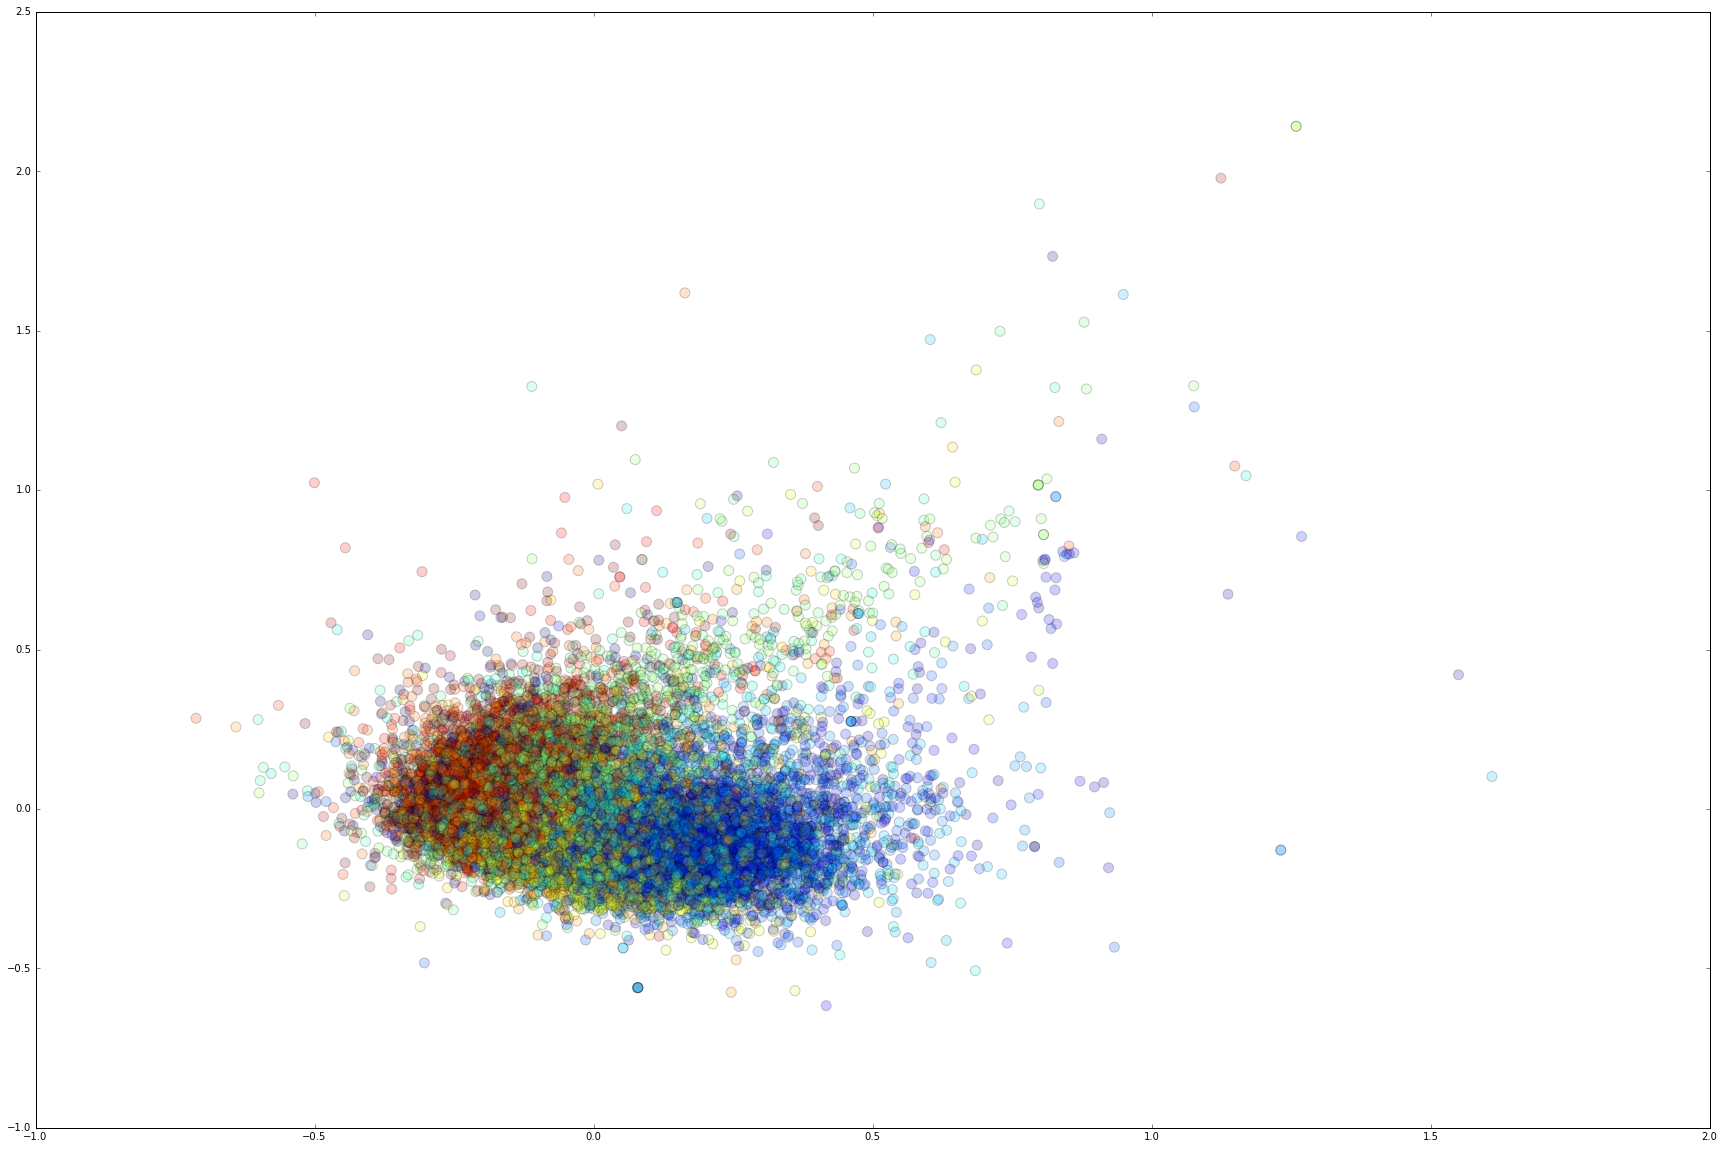

In [23]:
plt.figure(1, figsize=(30, 20),)
plt.scatter(x_pca[:, 0], x_pca[:, 1],s=100, c=y, alpha=0.2)

### Plot t-SNE

In [24]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, verbose=2).fit_transform(X)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 18282
[t-SNE] Computed conditional probabilities for sample 2000 / 18282
[t-SNE] Computed conditional probabilities for sample 3000 / 18282
[t-SNE] Computed conditional probabilities for sample 4000 / 18282
[t-SNE] Computed conditional probabilities for sample 5000 / 18282
[t-SNE] Computed conditional probabilities for sample 6000 / 18282
[t-SNE] Computed conditional probabilities for sample 7000 / 18282
[t-SNE] Computed conditional probabilities for sample 8000 / 18282
[t-SNE] Computed conditional probabilities for sample 9000 / 18282
[t-SNE] Computed conditional probabilities for sample 10000 / 18282
[t-SNE] Computed conditional probabilities for sample 11000 / 18282
[t-SNE] Computed conditional probabilities for sample 12000 / 18282
[t-SNE] Computed conditional probabilities for sample 13000 / 18282
[t-SNE] Computed conditional probabilities 

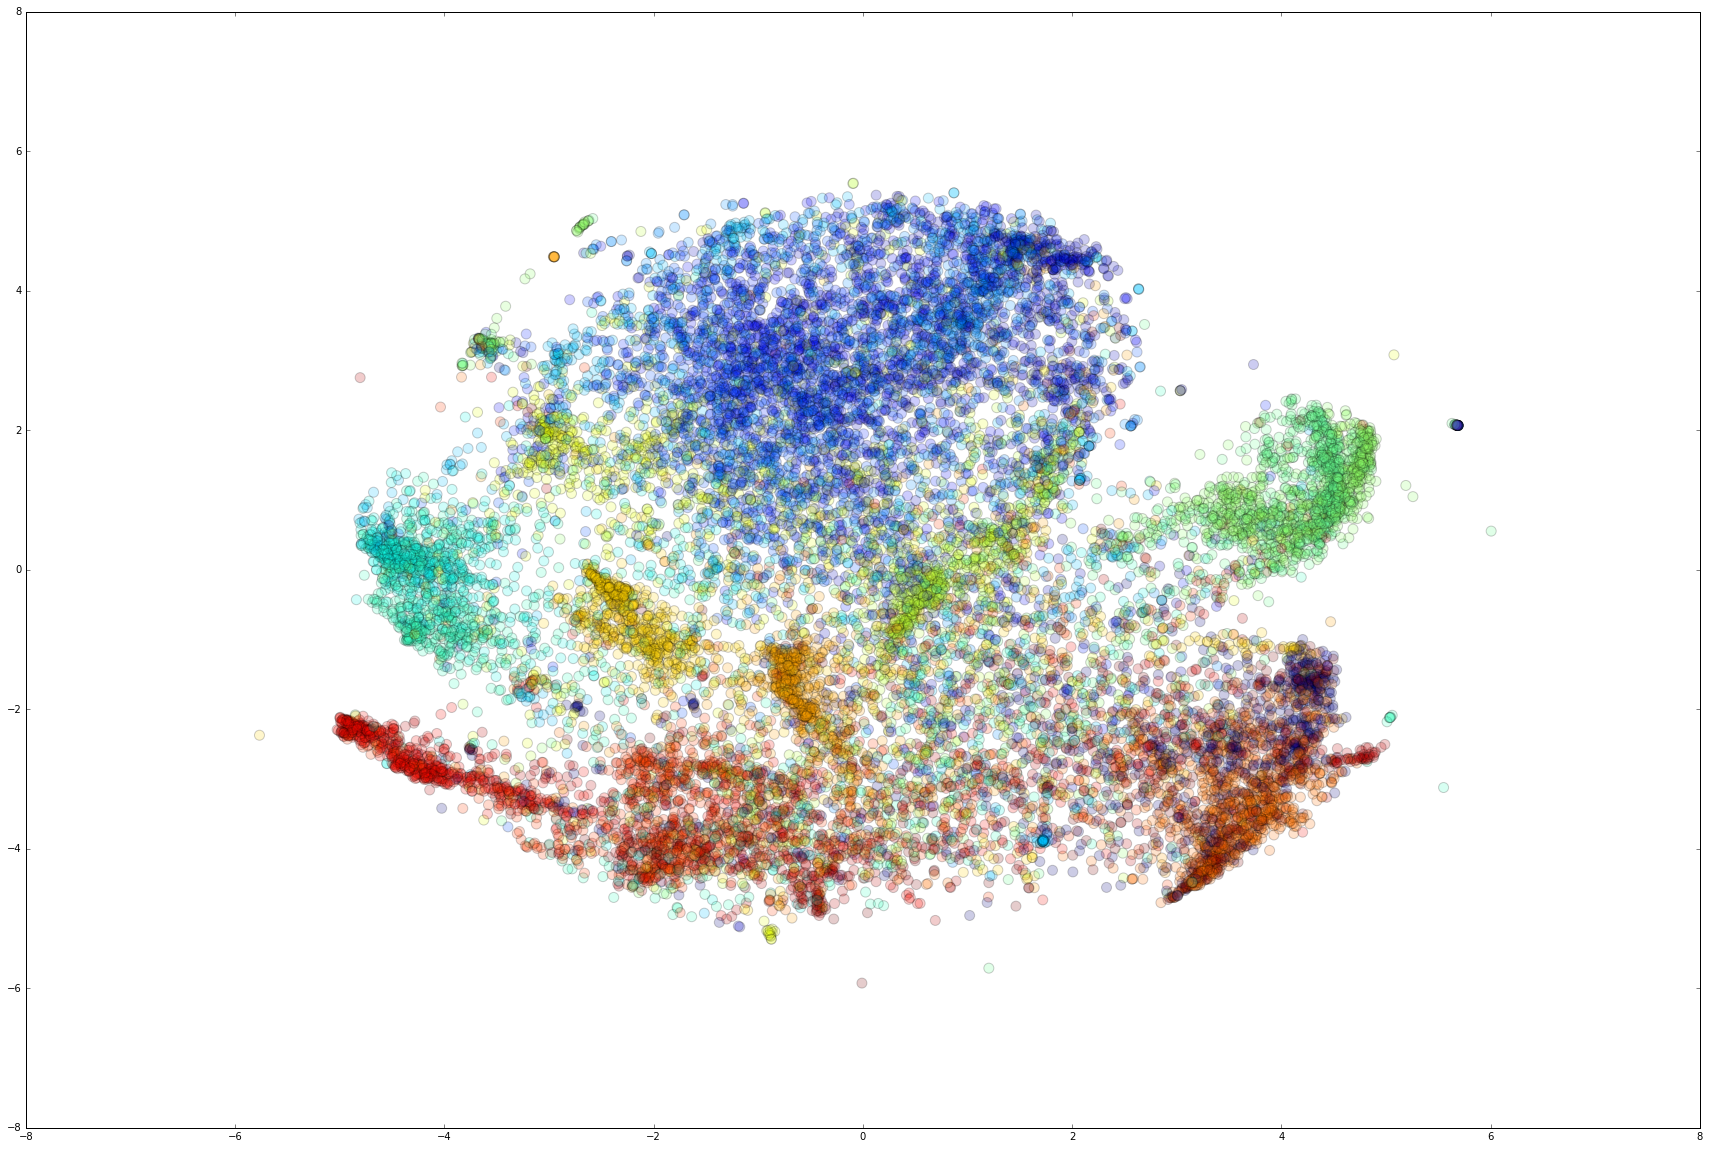

In [25]:
plt.figure(1, figsize=(30, 20),)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],s=100, c=y, alpha=0.2)